# Álvaro Huertas García

This notebook shows the pre-processing process and the selection of the optimal lemmatizer, stop words and N-grams. 

In [0]:
!pip install Unidecode

In [0]:
from google.colab import files
src = list(files.upload().values())[0]


Saving utils.py to utils.py


In [0]:
open('utils.py','wb').write(src)
import utils

In [0]:
import unidecode
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import sys
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


import spacy
print('spaCy Version: %s' % (spacy.__version__))
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
spaCy Version: 2.2.4


In [0]:
np.random.seed(1)

In [0]:
# Example of using pickle
# pickle_out = open("clean_narratives.pkl", "wb") # file where we save the variable
# pickle.dump(clean_narratives, pickle_out) # variable and the file to save in 
# pickle_out.close()

# For downloading pickle document
# from google.colab import files
# files.download("clean_narratives.pkl")

# Load the data

In [0]:
COLAB = True

if COLAB:
    import urllib
    # Data
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1zJuh8XJTf_5hPZ8jVEUtGW1BnBZ6Yy4z",
                              "precision_medicine.zip")
    # Long stop word
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1PcVSBLgIpJVXAj4JD8_EQAGprte4zuyn",
                              "long_stop_words.txt")
    # Clinical stop words
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1M5a92cvQ3L7okuYHBuZh2K1f_MsrupuF",
                              "clinical_stop_words.txt")
    # Pickle files
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1oiuWV41Gad28sFJpZTHJXo9h9y-fHi1S",
                              "clean_text_spacy.pkl")
    
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1Hi3cnn0R8lv4-9XhRiqbI3wokMbAwgzy",
                              "clean_text_nltk.pkl")
    
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1dNF87JwVZIVGmnco59Jz20dlejPbCM9Y",
                              "clean_text_clinical_nltk.pkl")

    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=13ygPL6iRyLk345o-M1bAFrMcfhu4etOV",
                              "clean_text_long_nltk.pkl")
    
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1bnC8wr255qwlJSjqgTecaHfKmHefFtad",
                              "clean_text_nltk_nltk.pkl")    
    
    # Model results
    # SVC lineal
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=18v2-hH-5PVpQlbgs0OYomIRxFhWJrCC0",
                              "svc_lineal.pkl")    
    # SVC no lineal, kernel rbf, C = 10, gamma = auto
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1-LaPrCBSp2Bu3zfaSntrPj8WwY5DeS1w",
                              "svc_rbf_C10.pkl") 
    
    # Plots 
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1cVtadtLLZRygteBHxUsqPR-aCiUyejDW",
                              "utils") 

In [0]:
f = open("long_stop_words.txt", "+r")
long_stopwords = f.read().split("\n")
len(long_stopwords)

853

In [0]:
from nltk.corpus import stopwords
 
len(stopwords.words('english'))

179

In [0]:
f = open("clinical_stop_words.txt", "+r")
clinical_stopwords = f.read().split("\n")
len(clinical_stopwords)

811

In [0]:
!unzip precision_medicine.zip 

Archive:  precision_medicine.zip
replace precision_medicine/Alzheimer_abstracts.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [0]:
files = [('Alzheimer_abstracts.tsv', 'Alzheimer'),
         ('Bladder_Cancer_abstracts.tsv', 'Bladder Cancer'),
         ('Breast_Cancer_abstracts.tsv', 'Breast Cancer'),
         ('Cervical_Cancer_abstracts.tsv', 'Cervical Cancer'),
         ('negative_abstracts.tsv', 'Negative'),]

input_folder = './precision_medicine/'

In [0]:
def load_file(file_name):
    with open(file_name) as f:
        examples = []
        content = f.readlines()
        for l in content:
            aux = l.split('\t')
            examples.append((aux[0], (' '.join(aux[1:])).replace('\n', ' ')))
        return examples

In [0]:
# Variables donde almacenamos cada texto y su etiqueta
narratives = []
labels = []

# Para cada uno de los 5 archivos extraemos sus textos y le asignamos la etiqueta
for f,label in files:
    aux = load_file(input_folder + f)
    narratives.extend([x[1] for x in aux])
    labels.extend(len(aux)*[label])

labels = np.array(labels)

len(narratives), len(labels)

(5000, 5000)

# Data Visualization 

In [0]:
dic = {}
print(len(narratives))
unique_labels, counts = np.unique(labels, return_counts=True)
for aa,bb in zip(unique_labels,counts):
    print(aa+':', bb)
    dic[aa] = bb

5000
Alzheimer: 1000
Bladder Cancer: 1000
Breast Cancer: 1000
Cervical Cancer: 1000
Negative: 1000


## Data set visualization

In [0]:
import plotly.graph_objects as go
y_values = list(dic.values())
x_values = list(dic.keys())
fig = go.Figure(
    data=[go.Bar(x = x_values, y= y_values)],
    layout_title_text="Top 20 bigrams before pre-processing", 
    )
fig.update_layout(
    title="Category distribution in the dataset",
    xaxis_title="Category",
    yaxis_title="Frequency",
    font=dict(
        size=12,
        color="black"
    )
)
fig.show()

# Pre processing text


## Selection of stop word list from differente resources


In [0]:
# Stop words from Spacy
spacy_nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print(sorted(spacy_stopwords))

Number of stop words: 326
["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'ca', 'call', 'can', 'cannot', 'could', 'did', 'do', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', '

In [0]:
# Stop words from NLTK
nltk_stopwords = nltk.corpus.stopwords.words('english')
print('Number of stop words: %d' % len(nltk_stopwords))
print(sorted(nltk_stopwords))

Number of stop words: 179
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', 

Biomecial list of stop words applied by  (Ganesan, Lloyd & Sarkar, 2016) in "Discovering Related Clinical Concepts Using Large Amounts of Clinical Notes". They have used this list of stop words for entity recognition (NER). 

In [0]:
print('Number of stop words: %d' % len(clinical_stopwords))
print(sorted(clinical_stopwords))

Number of stop words: 811
['#####', '#####', '&amp', '&amp;', '&quot', '&quot;', 'a', 'abaft', 'abafter', 'abaftest', 'about', 'abouter', 'aboutest', 'above', 'abover', 'abovest', 'accordingly', 'aer', 'aest', 'afore', 'after', 'afterer', 'afterest', 'afterward', 'afterwards', 'again', 'against', 'aid', 'ain', 'albeit', 'all', 'aller', 'allest', 'alls', 'allyou', 'almost', 'along', 'alongside', 'already', 'also', 'although', 'always', 'amid', 'amidst', 'among', 'amongst', 'an', 'and', 'andor', 'anear', 'anent', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anywhere', 'apart', 'aparter', 'apartest', 'appear', 'appeared', 'appearing', 'appears', 'appropriate', 'appropriated', 'appropriater', 'appropriates', 'appropriatest', 'appropriating', 'are', 'ares', 'around', 'as', 'ases', 'aside', 'asides', 'asking', 'aslant', 'astraddle', 'astraddler', 'astraddlest', 'astride', 'astrider', 'astridest', 'at', 'athwart', 'atop', 'atween', 'aught', 'aughts', 'available', 'availabler'

The biggest stop words list found in https://countwordsfree.com/stopwords

In [0]:
print('Number of stop words: %d' % len(long_stopwords))
print(sorted(long_stopwords))

Number of stop words: 853
["'ll", "'ve", 'I', 'a', "a's", 'able', 'about', 'above', 'abroad', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'added', 'adj', 'adopted', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 'against', 'ago', 'ah', 'ahead', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'alongside', 'already', 'also', 'although', 'always', 'am', 'amid', 'amidst', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'apparently', 'appear', 'appreciate', 'appropriate', 'approximately', 'are', 'aren', "aren't", 'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'auth', 'available', 'away', 'awfully', 'b', 'back', 'backward', 'backwards', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'begin', 'beginning', 'beginning

## Venn Diagram

We are going to show the intersection of stop words in the different lists. 

In [0]:
!pip install venn

/usr/local/lib/python3.6/dist-packages/venn/_backwards_compatibility.py:17: UserWarning:

`get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead

/usr/local/lib/python3.6/dist-packages/venn/_backwards_compatibility.py:32: UserWarning:

`venn4()` is retained for backwards compatibility; use `venn()` instead



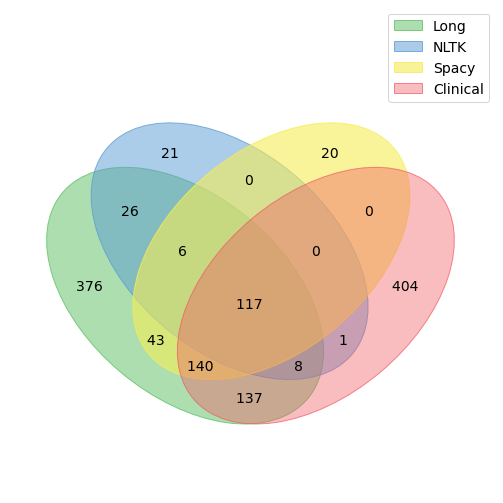

In [0]:
%matplotlib inline
import venn
venn_labels = venn.get_labels([set(long_stopwords), set(nltk_stopwords), set(spacy_stopwords), set(clinical_stopwords)], fill=['number'])
fig, ax = venn.venn4(venn_labels, names=['Long', 'NLTK', 'Spacy', 'Clinical'])
fig.show()

# Unicode example

In the preprocessing step we will encode all the text to Unicode. Here is an example that shows why it is important

In [0]:
import unidecode
text = chr(177)
print("ASCII character:", text)
text = unidecode.unidecode(text)
print("Unicode character:", text)

ASCII character: ±
Unicode character: +-


## Pre-processing

Here we define the preprocessor used by the TF-IDF vectorizer. 

In [0]:
def preprocessor(text, stoptext = "nltk", lemmatizer = "nltk"):
  sys.stdout.write('.')
  sys.stdout.flush()

  # Text to unicode
  text = unidecode.unidecode(text)

  # Remove introduction words for sections
  text = re.sub("[A-Z]{0,}\s[A-Z]+:", "", text) 

  # Lowercase and remove extra spaces
  text = text.strip().lower()

  # E mail
  text = re.sub(r"e\s?-\s?mail", "email", text)

  # Substitute p value
  text = re.sub('p\s?[<=]\s?0?[.,]0[0-5]+', 'hppv', text) # Significant
  text = re.sub('p\s?[>=]\s?[\d]+[.,]?\d*', 'lppv', text) # Non-significant

  # Separate punctation to replace numbers for NUM better
  from string import punctuation
  punctuation_marks = set(punctuation)
  punctuation_marks.update(chr(177))

  for i in punctuation_marks:
    element = "\\"+i # scape the character
    sub_element = " "+i+" " # Example "=" --> " = "
    text = re.sub(element, sub_element, text)


  # Substitute irrelevant (isolated) numbers by NUM
  text = re.sub( '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+[^A-Za-z]', " num ", text)
  text = re.sub( "\s[0-9]+\s", " num ", text)

  # Tokenize the text

  tokenized_text = nltk.word_tokenize(text)

  # Delete Punctuation
  tokenized_text = [i for i in tokenized_text if i not in punctuation_marks]

    # Delete stop words
  if stoptext == "spacy":
    stop_words = sorted(spacy_stopwords)

  if stoptext == "nltk":
    stop_words = sorted(nltk_stopwords)

  if stoptext == "clinical":
    stop_words = sorted(clinical_stopwords)

  if stoptext == "long":
    stop_words = sorted(long_stopwords)

  tokenized_text = [i for i in tokenized_text if i not in stop_words]


  # Lemmanization
  if lemmatizer == "nltk":
    lemmatizer = WordNetLemmatizer().lemmatize
    lemmatized_text = [lemmatizer(word) for word in tokenized_text]

  
  if lemmatizer == "spacy":
    nlp = spacy.load('en', disable=['parser', 'ner'])
    doc = nlp(" ".join(tokenized_text))
    lemmatized_text = [token.lemma_ for token in doc]


  # Join all the text  
  full_text = " ".join(lemmatized_text)

  return full_text

### Loading cleaning text with different approach. 

Due to the computational time that some apporaches takes, I load the cleaning text given by the combination of the different lemmatizer with the different stop words. The Spacy lemmatizer is too slow and shows any o tiny differences with NLTK lemmatizer. Thus, we have only computed one example using Spacy tokenizer. 

In [0]:
# 1 - Stop words: Clinical; Lemmatizer: NLTK

# Very quickly. However we also load a pickle object
# clean_narratives_clinical_nltk = [preprocessor(text, stoptext="clinical", lemmatizer="nltk")  for text in narratives]
pickle_in = open("clean_text_clinical_nltk.pkl", "rb")
clean_text_clinical_nltk = pickle.load(pickle_in)

In [0]:
# 2 - Stop words: Spacy; Lemmatizer: NLTK

# Very quickly. However we also load a pickle object
# clean_narratives_nltk = [preprocessor(text, stoptext="spacy", lemmatizer="nltk")  for text in narratives]
pickle_in = open("clean_text_nltk.pkl", "rb")
clean_text_nltk = pickle.load(pickle_in)

In [0]:
# 3 -  Stop words: Spacy; Lemmatizer: Spacy

# It takes long time. Better to load pickle file
# clean_narratives = [preprocessor(text, stoptext="spacy", lemmatizer="spacy")  for text in narratives]

# Pickle file
pickle_in = open("clean_text_spacy.pkl", "rb")
clean_text_spacy = pickle.load(pickle_in)

In [0]:
# 4 -  Stop words: Long; Lemmatizer: NLTK

# Very quickly. However we also load a pickle object
# clean_narratives_long_nltk = [preprocessor(text, stoptext="long", lemmatizer="nltk")  for text in narratives]
pickle_in = open("clean_text_long_nltk.pkl", "rb")
clean_text_long_nltk = pickle.load(pickle_in)

In [0]:
# 5 -  Stop words: NLTK; Lemmatizer: NLTK

# Very quickly. However we also load a pickle object
# clean_narratives_clinical_nltk = [preprocessor(text, stoptext="nltk", lemmatizer="nltk")  for text in narratives]
pickle_in = open("clean_text_nltk_nltk.pkl", "rb")
clean_text_nltk_nltk = pickle.load(pickle_in)

## Prepare Train and Test Data sets

Here we split the data in train and test set, extract features using TF-IDF approach and encode the label of each class. The fuctions accept the argument `n_grams` because we will study the efecto of using unigrams, bigrams and trigrams. 

In [0]:
def split_encode(clean_text, labels):
  # Split data
  X_train, X_test, Y_train, Y_test = model_selection.train_test_split(clean_text, labels, test_size=0.3, random_state = 0)
  
  # Encode label
  Encoder = LabelEncoder() 
  Y_train = Encoder.fit_transform(Y_train)
  Y_test = Encoder.fit_transform(Y_test)

  # Retrieve original label
  train_labels = Encoder.classes_[Y_train]
  test_labels = Encoder.classes_[Y_test]

  # Show codification
  codification = [ (Encoder.transform(Encoder.classes_)[i], Encoder.classes_[i])  for i in range(len(Encoder.classes_))]
  print("Label codification: \n", codification)
  
  return X_train, X_test, Y_train, Y_test , train_labels, test_labels

In [0]:
def tfi_df_ngram(clean_text, labels, max_features = 5000, n_gram = 3, max_df = 0.2, min_df = 3):
  # Split data
  X_train, X_test, Y_train, Y_test, train_labels, test_labels = split_encode(clean_text, labels)

  # Create vectorizer
  Tfidf_vect = TfidfVectorizer(max_features=max_features, min_df = min_df, max_df=max_df, 
                    strip_accents='unicode', analyzer='word',
                    ngram_range=(1, n_gram))
  
  # Fit train
  Tfidf_vect.fit(X_train)
  vocab = Tfidf_vect.vocabulary_

  
  # Transform data
  X_train_Tfidf = Tfidf_vect.transform(X_train)
  X_test_Tfidf = Tfidf_vect.transform(X_test)

  return X_train_Tfidf, X_test_Tfidf, Y_train, Y_test, vocab, train_labels, test_labels, X_train

In the following cell, the `clean text` can be changed by loaded above. Also, the number of words in the vocabulary (`max_features`) and the presence of bigrams or tigrams can be chosen. 

In [0]:
X_train_tf, X_test_tf, Y_train, Y_test, vocab, train_labels, test_labels, non_vector_train = tfi_df_ngram(clean_text_long_nltk,
                                                                                                          labels = labels, 
                                                                                                          max_features=8500, 
                                                                                                          n_gram=2,
                                                                                                          max_df = 0.7,
                                                                                                          min_df = 0)

Label codification: 
 [(0, 'Alzheimer'), (1, 'Bladder Cancer'), (2, 'Breast Cancer'), (3, 'Cervical Cancer'), (4, 'Negative')]


Check the result of the preprocessing step

In [0]:
non_vector_train[0]

'nipple areola sparing mastectomy treatment breast cancer efficacy safety nipple sparing mastectomy areola sparing mastectomy treatment breast cancer questionable estimated local recurrence rate nipple sparing mastectomy breast conserving surgery radiotherapy ass efficacy safety nipple sparing mastectomy areola sparing mastectomy treatment ductal carcinoma situ invasive breast cancer woman searched cochrane breast cancer group specialized register cochrane center register controlled trial central medline pubmed embase ovid lilac biblioteca virtual em saude bvs search term `` nipple sparing mastectomy `` `` areola sparing mastectomy `` searched health organization international clinical trial registry platform clinicaltrials gov search conducted 30th september num apply language restriction randomised controlled trial rcts rcts expanded criterion include randomised comparative study cohort case control study study evaluated nipple sparing areola sparing mastectomy compared modified radi

## Correct speelling 


We will use t TextBlob  Spelling correction `correct()` to check the spelling of the bigrams. 

In [0]:
from textblob import TextBlob
# Example of correct spelling
b = TextBlob("I havv goood speling!")
print(b.correct())

b = TextBlob("brast cancer")
print(b.correct())

I have good spelling!
breast cancer


# Word cloud

Check the top 100 bigram

In [0]:
!git clone https://github.com/amueller/word_cloud.git
!pip install word_cloud/

fatal: destination path 'word_cloud' already exists and is not an empty directory.
Processing ./word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post43+gd1ec087-cp36-cp36m-linux_x86_64.whl size=338572 sha256=798947b4e2fad240481f269fcf6d1228d24afa0b662ff947ebdfdafa6c7213da
  Stored in directory: /tmp/pip-ephem-wheel-cache-rz5g3rfb/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.6.0.post43+gd1ec087
    Uninstalling wordcloud-1.6.0.post43+gd1ec087:
      Successfully uninstalled wordcloud-1.6.0.post43+gd1ec087


In [0]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
bigrams = [ (i[0], len(re.findall(rf"{i[0]}", ' '.join(clean_text_long_nltk)) ) ) for i in vocab.items() if len(i[0].split()) >= 2 and "num" not in i[0]]
dic = {}
for tupla in bigrams:
  bigram = tupla[0]
  freq = tupla[1]
  dic[bigram] = freq

# Sorting the dicctionay
dict_bigram_freq = collections.OrderedDict(sorted(dic.items(), key= lambda k: k[1], reverse=True)) 

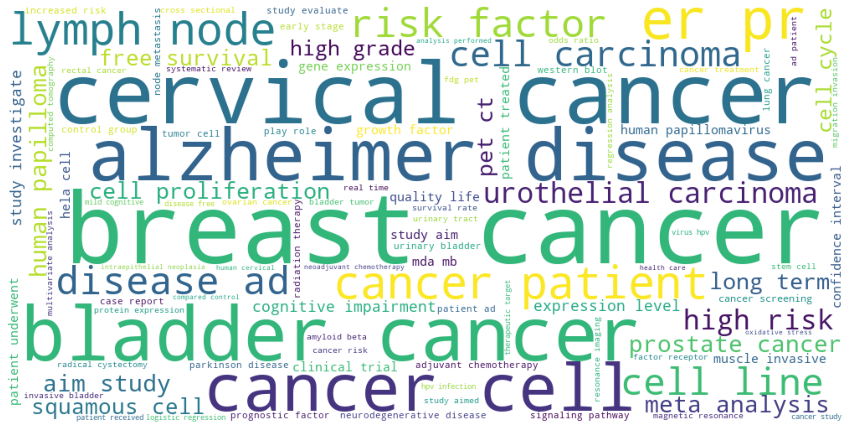

In [0]:
wordcloud = WordCloud(width = 1000, height = 500, background_color="white", max_words=100).generate_from_frequencies(dict_bigram_freq)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('yourfile.png', bbox_inches='tight')
# plt.close()

Now we check the distribution of categories in the train and test set. 

In [0]:
import plotly.graph_objects as go
import collections

dic = collections.Counter(train_labels)
y_values = list(dic.values())
x_values = list(dic.keys())
fig = go.Figure(
    data=[go.Bar(x = x_values, y= y_values)],
    layout_title_text="Top 20 bigrams before pre-processing", 
    )
fig.update_layout(
    title="Category distribution in the train dataset",
    xaxis_title="Category",
    yaxis_title="Frequency",
    font=dict(
        size=16,
        color="black"
    )
)
fig.show()

In [0]:
import plotly.graph_objects as go
import collections

dic = collections.Counter(test_labels)
y_values = list(dic.values())
x_values = list(dic.keys())
fig = go.Figure(
    data=[go.Bar(x = x_values, y= y_values)],
    layout_title_text="Top 20 bigrams before pre-processing", 
    )
fig.update_layout(
    title="Category distribution in the train dataset",
    xaxis_title="Category",
    yaxis_title="Frequency",
    font=dict(
        size=16,
        color="black"
    )
)
fig.show()

# Visualization

## T-SNE 2D and 3D


In [0]:
d = dict(zip(set(train_labels), ["blue", "yellow", "green", "red", "orange"]))
colors = [ d[train_labels[i]]   for i in range(len(train_labels))]

In [0]:
# importing bokeh library for interactive data visualization
from bokeh.palettes import Category10_5
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import pandas as pd

# defining the chart
output_notebook()
fig = bp.figure(plot_width=800, plot_height=700, title="A map of train text (interactive legend)",
                tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                x_axis_type=None, y_axis_type=None, min_border=1)

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(X_train_tf)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['text'] = list(X_train_tf)
tsne_df["label"] = train_labels
tsne_df["color"] = colors
tsne_df["tokens"] = [lines[:200] for lines in non_vector_train]

# Select differnt text class
alzhemier = tsne_df[tsne_df["label"] == "Alzheimer"][["x", "y", "label", "tokens"]]
bladder = tsne_df[tsne_df["label"] == "Bladder Cancer"][["x", "y", "label", "tokens"]]
breast = tsne_df[tsne_df["label"] == "Breast Cancer"][["x", "y", "label", "tokens"]]
cervical = tsne_df[tsne_df["label"] == "Cervical Cancer"][["x", "y", "label", "tokens"]]
negative = tsne_df[tsne_df["label"] == "Negative"][["x", "y", "label", "tokens"]]

# Data list
data_list = [alzhemier, bladder, breast, cervical, negative]

# Labels for the plot
name_list = ["Alzheimer", "Bladder Cancer", "Breast Cancer", "Cervical", "Negative"]

# plotting. the corresponding word appears when you hover on the data point.
for data, name, color in zip(data_list, name_list, Category10_5):
    fig.scatter(x='x', y='y', source=data, color = color, legend_label = name, 
                size = 5)


fig.legend.location = "top_left"
fig.legend.click_policy="hide"
hover = fig.select(dict(type=HoverTool))
hover.tooltips={"Category": "@label", "First tokens": "@tokens"}


show(fig)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3500 samples in 0.003s...
[t-SNE] Computed neighbors for 3500 samples in 0.915s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3500
[t-SNE] Computed conditional probabilities for sample 2000 / 3500
[t-SNE] Computed conditional probabilities for sample 3000 / 3500
[t-SNE] Computed conditional probabilities for sample 3500 / 3500
[t-SNE] Mean sigma: 0.308025


KeyboardInterrupt: ignored

In [0]:
import plotly.express as px

# dimensionality reduction. converting the vectors to 2d vectors
tsne_model = TSNE(n_components=3, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(X_train_tf)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v , columns=['x', 'y', "z"])
tsne_df['text'] = list(X_train_tf)
tsne_df["label"] = train_labels
tsne_df["color"] = colors


fig = px.scatter_3d(tsne_df, x="x", y='y', z='z',
              color="label")




fig.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title="T-SNE Text",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title")


fig.update_layout(legend= {'itemsizing': 'constant'})

for trace in fig.data:
    trace.name = trace.name.split('=')[1]
fig.show()

# PCA 2D and 3D

In [0]:
# importing bokeh library for interactive data visualization
from bokeh.palettes import Category10_5
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import pandas as pd

from sklearn.decomposition import PCA

# defining the chart
output_notebook()
fig = bp.figure(plot_width=700, plot_height=600, title="A map of documents (PCA)",
                tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                x_axis_type=None, y_axis_type=None, min_border=1)



# dimensionality reduction. converting the vectors to 2d vectors
pca = PCA(n_components=2)
wv_pca = pca.fit_transform(X_train_tf.todense())
print("Explained variance", pca.explained_variance_ratio_)

# putting everything in a dataframe
tsne_df = pd.DataFrame(wv_pca, columns=['x', 'y'])
tsne_df['text'] = list(X_train_tf)
tsne_df["label"] = train_labels
tsne_df["color"] = colors
tsne_df["tokens"] = [lines[:200] for lines in non_vector_train]

# Select differnt text class
alzhemier = tsne_df[tsne_df["label"] == "Alzheimer"][["x", "y", "label", "tokens"]]
bladder = tsne_df[tsne_df["label"] == "Bladder Cancer"][["x", "y", "label", "tokens"]]
breast = tsne_df[tsne_df["label"] == "Breast Cancer"][["x", "y", "label", "tokens"]]
cervical = tsne_df[tsne_df["label"] == "Cervical Cancer"][["x", "y", "label", "tokens"]]
negative = tsne_df[tsne_df["label"] == "Negative"][["x", "y", "label", "tokens"]]

# Data list
data_list = [alzhemier, bladder, breast, cervical, negative]

# Labels for the plot
name_list = ["Alzheimer", "Bladder Cancer", "Breast Cancer", "Cervical", "Negative"]

# plotting. the corresponding word appears when you hover on the data point.
for data, name, color in zip(data_list, name_list, Category10_5):
    fig.scatter(x='x', y='y', source=data, color = color, legend_label = name, 
                size = 5)

fig.yaxis.axis_label = "Pressure"

fig.legend.label_text_font_size = "24px"
fig.legend.location = "top_left"
fig.legend.click_policy="hide"
hover = fig.select(dict(type=HoverTool))
hover.tooltips={"Category": "@label", "First tokens": "@tokens"}


show(fig)

In [0]:
import plotly.express as px

# dimensionality reduction. converting the vectors to 2d vectors
pca = PCA(n_components=3)
wv_pca = pca.fit_transform(X_train_tf.todense())

# putting everything in a dataframe
tsne_df = pd.DataFrame(wv_pca , columns=['x', 'y', "z"])
tsne_df['text'] = list(X_train_tf)
tsne_df["label"] = train_labels
tsne_df["color"] = colors


fig = px.scatter_3d(tsne_df, x="x", y='y', z='z',
              color="label")




fig.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title="PCA Text",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title")


fig.update_layout(legend= {'itemsizing': 'constant'})

for trace in fig.data:
    trace.name = trace.name.split('=')[1]
fig.show()

We will use different measures [[link](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2)]:

Precision, which answers the following question: what proportion of predicted Positives is truly Positive?  We need to look at the total number of predicted Positives (the True Positives plus the False Positives, TP+FP), and see how many of them are True Positive (TP)

Another very useful measure is recall, which answers a different question: what proportion of actual Positives is correctly classified?

# Naive Bayes

In [0]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_tf, Y_train)

# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test_tf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(Y_test, predictions_NB)*100)
# Print the precision and recall, among other metrics
print(metrics.classification_report(Y_test, predictions_NB, digits=3))
# Print the confusion matrix
print(metrics.confusion_matrix(Y_test, predictions_NB))

## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=True, solver='lbfgs', random_state=0, max_iter=200)

model.fit(X_train_tf, Y_train)


# predict the labels on validation dataset
predictions_LR = model.predict(X_test_tf)

# Use accuracy_score function to get the accuracy
print("Logistic Regression Accuracy Score -> ",accuracy_score(Y_test, predictions_LR)*100)
print(metrics.classification_report(Y_test, predictions_LR))

# L1

In [0]:
param_grid = {'C': np.logspace(-3, 1, 6)} 

gs_Lr = GridSearchCV(LogisticRegression(penalty='l1', max_iter=1000, n_jobs=-1, solver = "liblinear"), cv=5, param_grid=param_grid)
gs_Lr.fit(X_train_tf, Y_train)

# predict the labels on validation dataset
predictions_Lr = gs_Lr.predict(X_test_tf)

# Use accuracy_score function to get the accuracy
print("Logistic Regression Lasso L1 Accuracy Score -> ",accuracy_score(Y_test, predictions_Lr)*100)
print('Best C Parameter: %.2g' % gs_Lr.best_params_['C'])
print(metrics.classification_report(Y_test, predictions_Lr))

# L2

In [0]:
param_grid = {'C': np.logspace(-3, 1, 6)} 

gs_L2 = GridSearchCV(LogisticRegression(penalty='l2', max_iter=100, n_jobs=-1, solver='saga', multi_class='multinomial'), cv=5, param_grid=param_grid)
gs_L2.fit(X_train_tf, Y_train)

# predict the labels on validation dataset
predictions_L2 = gs_L2.predict(X_test_tf)

# Use accuracy_score function to get the accuracy
print("Logistic Rdige Regression L2 Accuracy Score -> ",accuracy_score(Y_test, predictions_L2)*100)
print('Best C Parameter: %.2g' % gs_L2.best_params_['C'])
print(metrics.classification_report(Y_test, predictions_L2))

# KNN

In [0]:
from sklearn.metrics import  make_scorer
from sklearn.neighbors import KNeighborsClassifier

# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors':[1, 3, 5, 7, 11, 15, 20, 25, 30, 50, 100, 150, 200]}]

scores = ["accuracy"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
          
    knn = GridSearchCV(
        KNeighborsClassifier(), tuned_parameters, scoring=make_scorer(accuracy_score), cv = 10 
      )
      
    knn.fit(X_train_tf, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(knn.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = knn.cv_results_['mean_test_score']
    stds = knn.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, knn.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, knn.predict(X_test_tf)
    print("KNN Accuracy Score -> ",accuracy_score(y_true, y_pred)*100, knn.best_params_)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Random Forest

In [0]:
from sklearn.metrics import  make_scorer
from sklearn.ensemble import RandomForestClassifier

# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators':[50, 100, 150, 200],
                     'max_depth': [1, 3, 5, 7]}]

scores = ["accuracy"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
          
    knn = GridSearchCV(
        RandomForestClassifier( max_depth=3, random_state=0), tuned_parameters, scoring=make_scorer(accuracy_score), cv = 10 
      )
      
    knn.fit( X_train_tf, Y_train)

    print("Best parameters set found on development set:")
    print()
    print(knn.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = knn.cv_results_['mean_test_score']
    stds = knn.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, knn.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, knn.predict(X_test_tf)
    print("RF Accuracy Score -> ",accuracy_score(y_true, y_pred)*100, knn.best_params_)
    print(metrics.classification_report(y_true, y_pred))
    print()

In [0]:


rf = RandomForestClassifier( random_state=0, max_depth = 5, n_estimators = 200)
rf.fit(X_train_tf, Y_train)

# predict the labels on validation dataset
predictions_rf = rf.predict(X_test_tf)

# Use accuracy_score function to get the accuracy
print("Random Forest Accuracy Score -> ",accuracy_score(Y_test, predictions_rf)*100)

print(metrics.classification_report(Y_test, predictions_rf))

## SVM and SGD

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
clf_sv = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40, max_iter=10000) #Support Vector machines
clf_sgd = SGDClassifier(max_iter=200,) # Stochastic Gradient Classifier

In [0]:
%%time
from sklearn.model_selection import cross_val_score

clfs = [clf_sv, clf_sgd]
cv = 5
for clf in clfs:
    scores = cross_val_score(clf, X_train_tf, Y_train, cv=cv, scoring="accuracy" )
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), np.std(scores)))

In [0]:
%%time
from sklearn.metrics import classification_report

# 
clf_sv.fit(X_train_tf, Y_train )
y_pred = clf_sv.predict(X_test_tf)
print("###### SVC ######")
print("Accuracy:",accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))



clf_sgd.fit(X_train_tf, Y_train )
y_pred = clf_sgd.predict(X_test_tf)
print("###### SGD ######")
print("Accuracy:",accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))

In [0]:
param_grid = {'C': [1, 10]} 

gs_sv = GridSearchCV(svm.SVC(kernel='rbf'), cv=5, param_grid=param_grid)
gs_sv.fit(X_train_tf, Y_train)

y_pred = gs_sv.predict(X_test_tf)
print("###### SVC Kernel RBF ######")
print('Best C Parameter: %.2g' % gs_sv.best_params_['C'])
print("Accuracy:",accuracy_score(Y_test, y_pred))
print(metrics.classification_report(Y_test, y_pred))

## Confussion Matrix and Heatmap

In [0]:
classes = ["Alzheimer", "Bladder Cancer", "Breast Cancer", "Cervical Cancer", "Negative"]

In [0]:
import matplotlib.pyplot as plt
from utils import heatmap, annotate_heatmap
from sklearn.metrics import confusion_matrix
%matplotlib inline

matrix = confusion_matrix(Y_test, predictions_rf)
fig, ax = plt.subplots(figsize=(15,15))
im, cbar = heatmap(matrix, classes, classes, ax=ax,
                   cmap="OrRd", cbarlabel="Number of samples")
ax.set_ylabel('True value', fontsize = 18)
ax.set_xlabel('Predicted value', fontsize = 18)
ax.set_title("Random Forest (Long stopword, NLTK Lemmatizer, Bigrams)", fontsize = 20)
fig.patch.set_facecolor('lightgrey')
texts = annotate_heatmap(im, valfmt="{x:.0f}")


# Word2vec

From the clean pre-proccesed text we will build the word embedding. Firstly, we split the corpus to fit Word2Vec only in train data. 

In [0]:
import gensim # pip install gensim
from gensim.models.word2vec import Word2Vec # word2vec model gensim class
TaggedDocument = gensim.models.doc2vec.TaggedDocument

In [0]:
from sklearn.model_selection import train_test_split

narratives_tr, narratives_te, y_tr, y_te = train_test_split(clean_text_clinical_nltk, labels,
                                                            test_size=0.3, random_state=1)

In [0]:
tokenized_tr = [ nltk.word_tokenize(text) for text in narratives_tr]
print(tokenized_tr[0])
tokenized_te = [ nltk.word_tokenize(text) for text in narratives_te]

['applying', 'rapidplan', 'model', 'trained', 'technique', 'orientation', 'feasibility', 'dosimetric', 'evaluation', 'development', 'dose', 'volume', 'histogram', 'dvh', 'estimation', 'model', 'knowledge', 'based', 'planning', 'time', 'consuming', 'inefficient', 'similar', 'upcoming', 'case', 'supposed', 'clinically', 'desirable', 'explore', 'validate', 'potential', 'application', 'configured', 'model', 'study', 'test', 'hypothesis', 'supine', 'volumetric', 'modulated', 'arc', 'therapy', 'vmat', 'model', 'can', 'optimize', 'intensity', 'modulated', 'radiotherapy', 'imrt', 'plan', 'setup', 'orientation', 'based', 'rapidplan', 'dvh', 'estimation', 'model', 'trained', 'using', 'num', 'supine', 'vmat', 'rectal', 'plan', 'validated', 'num', 'similar', 'case', 'ensure', 'robustness', 'designed', 'purpose', 'attempt', 'made', 'apply', 'model', 'optimize', 'dynamic', 'mlc', 'sequence', 'duplicated', 'imrt', 'plan', 'num', 'historical', 'patient', 'num', 'prone', 'num', 'supine', 'treated', 'pr

In [0]:
vec_dim = 128
#vec_dim = 32

# se declara un word2vec:
w2v = Word2Vec(size=vec_dim, min_count=10, window=10, iter=5) #min_count = 100 # min_count = 1

# se construye el vocabulario de word2vec con los datos de training:
w2v.build_vocab(tokenized_tr)

# se entrena word2vec con los datos de training:
w2v.train(tokenized_tr, total_examples=w2v.corpus_count, epochs=w2v.epochs)

(2071492, 2617240)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
print('building tf-idf matrix ...')
max_features = 5000
vectorizer = TfidfVectorizer(max_features=max_features, min_df=0, max_df=0.8, 
                    strip_accents='unicode', ngram_range=(1, 3))
                                                                            
vectorizer.fit(narratives_tr)
IDFs = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('size of vocabulary obtained with TfidfVectorizer:', len(IDFs))
print('size of vocabulary obtained with word2vec:', len(w2v.wv.vocab))
print("Some idfs:")
aux = list(IDFs.items())
for i in list(range(3))+list(range(1000,1005)):
    print("  ", aux[i])

building tf-idf matrix ...
size of vocabulary obtained with TfidfVectorizer: 5000
size of vocabulary obtained with word2vec: 5741
Some idfs:
   ('11c', 6.762908648156295)
   ('18f', 5.376614287036404)
   ('18f fdg', 5.98275009060672)
   ('conversion', 5.98275009060672)
   ('copd', 6.85821882796062)
   ('copper', 6.116281483231242)
   ('copy', 5.98275009060672)
   ('copy number', 6.521746591339407)


In [0]:
# Función para codificar cada texto como un solo vector

def Text2Vec(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v.wv[word].reshape((1, size)) * IDFs[word] # el embedding lo multiplica por el IDF
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

## Embedding of the train biomedical text data set

In [0]:
from tqdm import tqdm # pip install tqdm
vecs_train = np.zeros((len(tokenized_tr), vec_dim))
for i,x in tqdm(enumerate(tokenized_tr)):
    vecs_train[i] = Text2Vec(x, vec_dim)

vecs_test = np.zeros((len(tokenized_te), vec_dim))
for i,x in tqdm(enumerate(tokenized_te)):
    vecs_test[i] = Text2Vec(x, vec_dim)

3500it [00:03, 1104.48it/s]
1500it [00:01, 1142.12it/s]


## Text visualization

In [0]:
set(y_tr)

In [0]:
d = dict(zip(set(y_tr), ["blue", "yellow", "green", ""]))



### T-SNE Text

In [0]:
# importing bokeh library for interactive data visualization
from bokeh.palettes import Category10_5
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import pandas as pd

# defining the chart
output_notebook()
fig = bp.figure(plot_width=800, plot_height=700, title="A map of train text (interactive legend)",
                tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                x_axis_type=None, y_axis_type=None, min_border=1)

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(vecs_train)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['text'] = list(vecs_train)
tsne_df["label"] = y_tr
tsne_df["color"] = colors
tsne_df["narrative"] = [x[:200] for x in narratives_tr]

# Select differnt text class
alzhemier = tsne_df[tsne_df["label"] == "Alzheimer"][["x", "y", "label", "narrative"]]
bladder = tsne_df[tsne_df["label"] == "Bladder Cancer"][["x", "y", "label", "narrative"]]
breast = tsne_df[tsne_df["label"] == "Breast Cancer"][["x", "y", "label", "narrative"]]
cervical = tsne_df[tsne_df["label"] == "Cervical Cancer"][["x", "y", "label", "narrative"]]
negative = tsne_df[tsne_df["label"] == "Negative"][["x", "y", "label", "narrative"]]

# Data list
data_list = [alzhemier, bladder, breast, cervical, negative]

# Labels for the plot
name_list = ["Alzheimer", "Bladder Cancer", "Breast Cancer", "Cervical", "Negative"]

# plotting. the corresponding word appears when you hover on the data point.
for data, name, color in zip(data_list, name_list, Category10_5):
    fig.scatter(x='x', y='y', source=data, color = color, legend_label = name, 
                size = 5)
    hover.tooltips={"text": "@label"}

fig.legend.location = "top_left"
fig.legend.click_policy="hide"
hover = fig.select(dict(type=HoverTool))
hover.tooltips={"Category": "@label", "Narratives (first lines)": "@narrative"}


show(fig)

In [0]:
import plotly.express as px

# dimensionality reduction. converting the vectors to 2d vectors
tsne_model = TSNE(n_components=3, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(vecs_train)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v , columns=['x', 'y', "z"])
tsne_df['text'] = list(vecs_train)
tsne_df["label"] = y_tr
tsne_df["color"] = colors


fig = px.scatter_3d(tsne_df, x="x", y='y', z='z',
              color="label")




fig.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title="T-SNE Text",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title")


fig.update_layout(legend= {'itemsizing': 'constant'})

for trace in fig.data:
    trace.name = trace.name.split('=')[1]
fig.show()

## PCA

In [0]:
# importing bokeh library for interactive data visualization
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

from sklearn.decomposition import PCA

# defining the chart
output_notebook()
fig = bp.figure(plot_width=700, plot_height=600, title="A map of word vectors (PCA)",
                tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                x_axis_type=None, y_axis_type=None, min_border=1)



# dimensionality reduction. converting the vectors to 2d vectors
pca = PCA(n_components=2)
wv_pca = pca.fit_transform(vecs_train)

# putting everything in a dataframe
tsne_df = pd.DataFrame(wv_pca, columns=['x', 'y'])
tsne_df['text'] = list(vecs_train)
tsne_df["label"] = y_tr
tsne_df["color"] = colors
tsne_df["narrative"] = [x[:200] for x in narratives_tr]


# Select differnt text class
alzhemier = tsne_df[tsne_df["label"] == "Alzheimer"][["x", "y", "label", "narrative"]]
bladder = tsne_df[tsne_df["label"] == "Bladder Cancer"][["x", "y", "label", "narrative"]]
breast = tsne_df[tsne_df["label"] == "Breast Cancer"][["x", "y", "label", "narrative"]]
cervical = tsne_df[tsne_df["label"] == "Cervical Cancer"][["x", "y", "label", "narrative"]]
negative = tsne_df[tsne_df["label"] == "Negative"][["x", "y", "label", "narrative"]]

# Data list
data_list = [alzhemier, bladder, breast, cervical, negative]

# Labels for the plot
name_list = ["Alzheimer", "Bladder Cancer", "Breast Cancer", "Cervical", "Negative"]

# plotting. the corresponding word appears when you hover on the data point.
for data, name, color in zip(data_list, name_list, Category10_5):
    fig.scatter(x='x', y='y', source=data, color = color, line_color = "DarkSlateGrey", legend_label = name, 
                size = 5, line_width = 1 )
    


fig.legend.location = "top_left"
fig.legend.click_policy="hide"
hover = fig.select(dict(type=HoverTool))
hover.tooltips={"Category": "@label", "Narratives (first lines)": "@narrative"}

show(fig)

In [0]:
import plotly.express as px

# dimensionality reduction. converting the vectors to 2d vectors
pca = PCA(n_components=3)
wv_pca = pca.fit_transform(vecs_train)

# putting everything in a dataframe
tsne_df = pd.DataFrame(wv_pca, columns=['x', 'y', "z"])
tsne_df['text'] = list(vecs_train)
tsne_df["label"] = y_tr
tsne_df["color"] = colors


fig = px.scatter_3d(tsne_df, x="x", y='y', z='z',
              color="label")




fig.update_traces(marker=dict(size=2,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title="PCA Text",
    xaxis_title="x Axis Title",
    yaxis_title="y Axis Title")

fig.update_layout(legend= {'itemsizing': 'constant'})

for trace in fig.data:
    trace.name = trace.name.split('=')[1]
fig.show()

## Word embedding visualization

In [0]:
# importing bokeh library for interactive data visualization
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import pandas as pd


# defining the chart
output_notebook()
fig = bp.figure(plot_width=700, plot_height=600, title="A map of word vectors",
                tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 1000. each is of 200 dimensions
word_vectors = [w2v.wv[w] for w in list(w2v.wv.vocab.keys())]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(w2v.wv.vocab.keys())

# plotting. the corresponding word appears when you hover on the data point.
fig.scatter(x='x', y='y', source=tsne_df)
hover = fig.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(fig)

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])        
X = pipeline.fit_transform(narratives_tr).todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c = colors)
plt.legend()
plt.show()  

# Modelos

## Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
Naive = naive_bayes.GaussianNB()
Naive.fit(vecs_train, y_tr)

# predict the labels on validation dataset
predictions_NB = Naive.predict(vecs_test)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(y_te, predictions_NB)*100)
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_te, predictions_NB, digits=3))
# Print the confusion matrix
print(metrics.confusion_matrix(y_te, predictions_NB))

Naive Bayes Accuracy Score ->  58.53333333333334
                 precision    recall  f1-score   support

      Alzheimer      0.844     0.799     0.821       304
 Bladder Cancer      0.483     0.628     0.546       323
  Breast Cancer      0.439     0.468     0.453       278
Cervical Cancer      0.701     0.373     0.487       295
       Negative      0.566     0.640     0.601       300

       accuracy                          0.585      1500
      macro avg      0.607     0.582     0.582      1500
   weighted avg      0.608     0.585     0.584      1500

[[243   2   6   0  53]
 [  1 203  66  26  27]
 [  1  87 130  15  45]
 [  0  97  66 110  22]
 [ 43  31  28   6 192]]


# SGD y SVC

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
clf_sv = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40, max_iter=20000) #Support Vector machines
clf_sgd = SGDClassifier(max_iter=200,) # Stochastic Gradient Classifier

from sklearn.metrics import classification_report

# 
clf_sv.fit(vecs_train, y_tr )
y_pred = clf_sv.predict(vecs_test)
print("###### SVC ######")
print("Accuracy:",accuracy_score(y_te, y_pred))
print(metrics.classification_report(y_te, y_pred))



clf_sgd.fit(vecs_train, y_tr )
y_pred = clf_sgd.predict(vecs_test)
print("###### SGD ######")
print("Accuracy:",accuracy_score(y_te, y_pred))
print(metrics.classification_report(y_te, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



###### SVC ######
Accuracy: 0.7626666666666667
                 precision    recall  f1-score   support

      Alzheimer       0.93      0.92      0.93       304
 Bladder Cancer       0.85      0.88      0.86       323
  Breast Cancer       0.65      0.65      0.65       278
Cervical Cancer       0.73      0.63      0.68       295
       Negative       0.64      0.71      0.68       300

       accuracy                           0.76      1500
      macro avg       0.76      0.76      0.76      1500
   weighted avg       0.76      0.76      0.76      1500

###### SGD ######
Accuracy: 0.6833333333333333
                 precision    recall  f1-score   support

      Alzheimer       0.91      0.88      0.90       304
 Bladder Cancer       0.91      0.74      0.81       323
  Breast Cancer       0.64      0.46      0.53       278
Cervical Cancer       0.46      0.85      0.60       295
       Negative       0.71      0.47      0.56       300

       accuracy                           0.68

## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=True, solver='lbfgs', random_state=0, max_iter=200)

model.fit(vecs_train, y_tr)


# predict the labels on validation dataset
predictions_LR = model.predict(vecs_test)

# Use accuracy_score function to get the accuracy
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_te, predictions_LR)*100)
print(metrics.classification_report(y_te, predictions_LR))

Logistic Regression Accuracy Score ->  75.8
                 precision    recall  f1-score   support

      Alzheimer       0.94      0.90      0.92       304
 Bladder Cancer       0.87      0.83      0.85       323
  Breast Cancer       0.62      0.68      0.65       278
Cervical Cancer       0.72      0.65      0.68       295
       Negative       0.65      0.71      0.68       300

       accuracy                           0.76      1500
      macro avg       0.76      0.76      0.76      1500
   weighted avg       0.76      0.76      0.76      1500



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# L1

In [353]:
param_grid = {'C': np.logspace(-3, 1, 6)} 

gs_Lr = GridSearchCV(LogisticRegression(penalty='l1', max_iter=1000, solver = "liblinear"), cv=5, param_grid=param_grid)
gs_Lr.fit(vecs_train, y_tr)

# predict the labels on validation dataset
predictions_Lr = gs_Lr.predict(vecs_test)

# Use accuracy_score function to get the accuracy
print("Logistic Regression Lasso L1 Accuracy Score -> ",accuracy_score(y_te, predictions_Lr)*100)
print('Best C Parameter: %.2g' % gs_Lr.best_params_['C'])
print(metrics.classification_report(y_te, predictions_Lr))

Logistic Regression Lasso L1 Accuracy Score ->  85.53333333333333
Best C Parameter: 10
                 precision    recall  f1-score   support

      Alzheimer       0.94      0.92      0.93       304
 Bladder Cancer       0.88      0.87      0.88       323
  Breast Cancer       0.83      0.85      0.84       278
Cervical Cancer       0.89      0.83      0.86       295
       Negative       0.75      0.81      0.78       300

       accuracy                           0.86      1500
      macro avg       0.86      0.85      0.86      1500
   weighted avg       0.86      0.86      0.86      1500



# L2

In [0]:
param_grid = {'C': np.logspace(-3, 1, 6)} 

gs_L2 = GridSearchCV(LogisticRegression(penalty='l2', max_iter=100, n_jobs=-1, solver='saga', multi_class='multinomial'), cv=5, param_grid=param_grid)
gs_L2.fit(vecs_train, y_tr)

# predict the labels on validation dataset
predictions_L2 = gs_L2.predict(vecs_test)

# Use accuracy_score function to get the accuracy
print("Logistic Regression Lasso L2 Accuracy Score -> ",accuracy_score(y_te, predictions_L2)*100)
print('Best C Parameter: %.2g' % gs_L2.best_params_['C'])
print(metrics.classification_report(y_te, predictions_L2))

Logistic Regression Lasso L2 Accuracy Score ->  75.33333333333333
Best C Parameter: 10
                 precision    recall  f1-score   support

      Alzheimer       0.93      0.89      0.91       304
 Bladder Cancer       0.87      0.84      0.85       323
  Breast Cancer       0.62      0.67      0.65       278
Cervical Cancer       0.71      0.62      0.66       295
       Negative       0.64      0.72      0.68       300

       accuracy                           0.75      1500
      macro avg       0.75      0.75      0.75      1500
   weighted avg       0.76      0.75      0.75      1500



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



# KNN

In [0]:
from sklearn.metrics import  make_scorer
from sklearn.neighbors import KNeighborsClassifier

# Set the parameters by cross-validation
tuned_parameters = [{'n_neighbors':[1, 3, 5, 7, 11, 15, 20, 25, 30, 50, 100, 150, 200]}]

scores = ["accuracy"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
          
    knn = GridSearchCV(
        KNeighborsClassifier(), tuned_parameters, scoring=make_scorer(accuracy_score), cv = 10 
      )
      
    knn.fit(vecs_train, y_tr)

    print("Best parameters set found on development set:")
    print()
    print(knn.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = knn.cv_results_['mean_test_score']
    stds = knn.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, knn.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_te, knn.predict(vecs_test)
    print("Accuracy Score -> ",accuracy_score(y_true, y_pred)*100)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_neighbors': 15}

Grid scores on development set:

0.567 (+/-0.046) for {'n_neighbors': 1}
0.603 (+/-0.044) for {'n_neighbors': 3}
0.631 (+/-0.050) for {'n_neighbors': 5}
0.632 (+/-0.042) for {'n_neighbors': 7}
0.637 (+/-0.058) for {'n_neighbors': 11}
0.640 (+/-0.054) for {'n_neighbors': 15}
0.634 (+/-0.061) for {'n_neighbors': 20}
0.638 (+/-0.052) for {'n_neighbors': 25}
0.633 (+/-0.060) for {'n_neighbors': 30}
0.632 (+/-0.048) for {'n_neighbors': 50}
0.610 (+/-0.029) for {'n_neighbors': 100}
0.586 (+/-0.037) for {'n_neighbors': 150}
0.572 (+/-0.045) for {'n_neighbors': 200}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

Accuracy Score ->  62.73333333333333
                 precision    recall  f1-score   support

      Alzheimer       0.87      0.84      0.85       304
 Bladder Cancer       0.62      0.71  

# Random Forest

In [0]:
from sklearn.metrics import  make_scorer
from sklearn.ensemble import RandomForestClassifier

# Set the parameters by cross-validation
tuned_parameters = [{'n_estimators':[50, 100, 150, 200, 300, 400, 500, 700],
                     'max_depth': [1, 3, 5, 7, 10]}]

scores = ["accuracy"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
          
    knn = GridSearchCV(
        RandomForestClassifier( max_depth=3, random_state=0), tuned_parameters, scoring=make_scorer(accuracy_score), cv = 10 
      )
      
    knn.fit( vecs_train, y_tr)

    print("Best parameters set found on development set:")
    print()
    print(knn.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = knn.cv_results_['mean_test_score']
    stds = knn.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, knn.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_te, knn.predict(vecs_test)
    print("Accuracy Score -> ",accuracy_score(y_true, y_pred)*100)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 700}

Grid scores on development set:

0.462 (+/-0.054) for {'max_depth': 1, 'n_estimators': 50}
0.470 (+/-0.053) for {'max_depth': 1, 'n_estimators': 100}
0.464 (+/-0.058) for {'max_depth': 1, 'n_estimators': 150}
0.463 (+/-0.059) for {'max_depth': 1, 'n_estimators': 200}
0.469 (+/-0.053) for {'max_depth': 1, 'n_estimators': 300}
0.475 (+/-0.056) for {'max_depth': 1, 'n_estimators': 400}
0.469 (+/-0.052) for {'max_depth': 1, 'n_estimators': 500}
0.463 (+/-0.048) for {'max_depth': 1, 'n_estimators': 700}
0.580 (+/-0.065) for {'max_depth': 3, 'n_estimators': 50}
0.587 (+/-0.066) for {'max_depth': 3, 'n_estimators': 100}
0.583 (+/-0.069) for {'max_depth': 3, 'n_estimators': 150}
0.579 (+/-0.065) for {'max_depth': 3, 'n_estimators': 200}
0.581 (+/-0.061) for {'max_depth': 3, 'n_estimators': 300}
0.581 (+/-0.061) for {'max_depth': 3, 'n_estimators': 400}
0.582 (+/-0.064)

# Confussion matrix and Heatmap

Label codification: 
 [(0, 'Alzheimer'), (1, 'Bladder Cancer'), (2, 'Breast Cancer'), (3, 'Cervical Cancer'), (4, 'Negative')]

In [0]:
classes = ["Alzheimer", "Bladder Cancer", "Breast Cancer", "Cervical Cancer", "Negative"]

In [0]:
import matplotlib.pyplot as plt
from utils import heatmap, annotate_heatmap
from sklearn.metrics import confusion_matrix
%matplotlib inline

matrix = confusion_matrix(y_te, predictions_Lr)
fig, ax = plt.subplots(figsize=(15,15))
im, cbar = heatmap(matrix, classes, classes, ax=ax,
                   cmap="OrRd", cbarlabel="Number of samples")
ax.set_ylabel('True value', fontsize = 16)
ax.set_xlabel('Predicted value', fontsize = 16)
ax.set_title("Logistic Regression L1 (Long stopwords, NLTK Lemmatizer, Word2vec size = 150)", fontsize = 18)
fig.patch.set_facecolor('lightgrey')
texts = annotate_heatmap(im, valfmt="{x:.0f}")
plt.savefig('')